<a href="https://colab.research.google.com/github/yingji15/DS-Interview-Preparation/blob/main/rdd_late_orders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# data wrangling
import pandas as pd
import numpy as np
np.random.seed(42) 

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
import statsmodels.formula.api as smf

# aesthetics
pd.options.mode.chained_assignment: None
%matplotlib inline

> **Question**: Can issuing refunds appease "[hangry](https://www.merriam-webster.com/dictionary/hangry)" DoorDash consumers receiving late orders? 

# predict customer lifetime value (LTV)
Each customer's lifetime value (LTV) $Y_i$ has the following relationship with the running variable $R_i$, order lateness (minutes late):

$$Y_i = \beta_0 + \beta_1(R_i - c) + \beta_2\mathbb{1}_{R_i \geq c} + \beta_3 (R_i - c)\cdot \mathbb{1}_{R_i \geq c} + \epsilon,$$
where $c$ (30 min) is DoorDash's cutoff for issuing a refund and the indicator function $\mathbb{1}_{R_i > c}$ uses this cutoff to determine whether a given order can get a refund (treatment: $\mathbb{1}_{R_i \geq c} = 1$) or not (control: $\mathbb{1}_{R_i > c} = 0)$.

<center>
    <img src="https://www.dropbox.com/s/uy338hsms3qiq3a/lateness.png?raw=1" width="400">
</center>

- **Untreated side** ($R_i < c$, $\mathbb{1}_{R_i > c} = 0$): $Y_i = \beta_0 + \beta_1(R_i - c) + \epsilon$ 
    - 👉 Intercept at cutoff (when $R_i = c$): $\beta_0$
- **Treated side** ($R_i \geq c$, $\mathbb{1}_{R_i > c} = 1$): $Y_i = (\beta_0 + \beta_2) + (\beta_1 + \beta_3)\cdot(R_i - c) + \epsilon$
    - 👉 Intercept at the cutoff (again $R_i = c$): $\beta_0 + \beta_2$
    
The treatment effect is the distance between the two intercepts: $(\beta_0 + \beta_2) - \beta_0 = \beta_2$

# generate data for regression

In [ ]:
# set parameter values (for centered running variable)
LOWER, CUTOFF, UPPER = 0, 30, 60
B0, B1, B2, B3 = 50, -0.8, 10, -0.1

In [ ]:
def generate_dataset(
    n, std, b0=B0, b1=B1, b2=B2, b3=B3, lower=LOWER, upper=UPPER, cutoff=CUTOFF
):
    """generate customer LTV under given order lateness and refund status"""

    # generate order lateness from uniform distribution
    min_late = np.random.uniform(lower, upper, n)

    # determine each order's refund status based on cutoff
    was_refunded = np.where(min_late < cutoff, 0, 1)

    # generate the error term from a normal distribution
    errors = np.random.normal(0, std, n)

    # use order lateness and refund status to predict LTV
    ltv = (
        b0
        + b1 * (min_late - cutoff)
        + b2 * was_refunded
        + b3 * (min_late - cutoff) * was_refunded
        + errors
    )

    # create dataframe for simulated data
    df_late = pd.DataFrame({"min_late": min_late, "ltv": ltv})

    # center running variable by cutoff
    df_late["min_late_centered"] = df_late["min_late"] - cutoff

    # assign treatment (refund)
    df_late["refunded"] = df_late["min_late"].apply(lambda x: 1 if x >= cutoff else 0)

    # return dataframe
    return df_late

# plot LTV by minutes late

In [ ]:
# generate data for 2,000 late orders
df_late = generate_dataset(2000, 10)
df_late.head()

,min_late,ltv,min_late_centered,refunded
0,22.472407,47.242248,-7.527593,0
1,57.042858,27.392624,27.042858,1
2,43.919637,45.207538,13.919637,1
3,35.919509,58.346097,5.919509,1
4,9.361118,75.646952,-20.638882,0


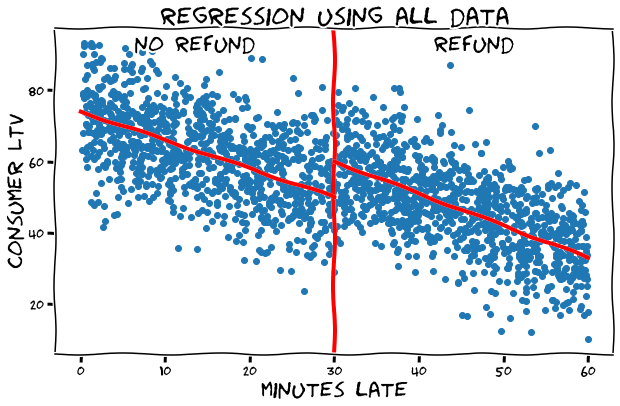

In [ ]:
with plt.xkcd():
    # plot relationship between LTV and minutes late
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(df_late["min_late"], df_late["ltv"])
    ax.set_xlabel("minutes late", fontsize=22)
    ax.set_ylabel("consumer LTV", fontsize=22)
    ax.set_title("regression using all data", fontsize=25)

    # draw vertical line to indicate cutoff
    ax.axvline(x=CUTOFF, linewidth=4, color="r")

    # draw regression line for untreated side
    x_untreated = np.linspace(LOWER, CUTOFF, 1000)
    ltv_untreated = B0 + B1 * (x_untreated - CUTOFF)
    ax.plot(x_untreated, ltv_untreated, linewidth=4, color="r")

    # draw regression for treated side
    x_treated = np.linspace(CUTOFF, UPPER, 1000)
    ltv_treated = (B0 + B2) + (B1 + B3) * (x_treated - CUTOFF)
    ax.plot(x_treated, ltv_treated, linewidth=4, color="r")

    # annotate refund status of each side
    ax.text(
        0.25,
        0.95,
        "no refund",
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
        fontsize=22,
    )

    ax.text(
        0.75,
        0.95,
        "refund",
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
        fontsize=22,
    )

    fig.savefig("rdd_all_data.png", dpi=300)

# regression discontinuity design

**References**: [Chapter 16](https://matheusfacure.github.io/python-causality-handbook/16-Regression-Discontinuity-Design.html) in *Causal Inference for The Brave and True* and [Chapter 20](https://www.theeffectbook.net/ch-RegressionDiscontinuity.html) in *The Effect*

## using all data

In [ ]:
# use treatment, running variable, and interactions to predict outcome
model_all_data = smf.wls("ltv ~ min_late_centered * refunded", df_late).fit()

In [ ]:
# model summary
model_all_data.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,50.5698,0.652,77.571,0.000,49.291,51.848
min_late_centered,-0.7599,0.037,-20.722,0.000,-0.832,-0.688
refunded,9.5552,0.904,10.566,0.000,7.782,11.329
min_late_centered:refunded,-0.1350,0.052,-2.617,0.009,-0.236,-0.034


The coefficient of `refunded` is the treatment effect: Getting a refund saves LTV by 9.55 dollars.

## kernel weighting

In [ ]:
def kernel(min_late, cutoff, bandwidth):
    """assign weight to each data point (0 if outside bandwdith)"""

    # assign weight based on distance to cutoff
    weight = np.where(
        np.abs(min_late - cutoff) <= bandwidth,
        (1 - np.abs(min_late - cutoff) / bandwidth),
        0.0000000001,  # ≈ 0 outside bandwidth (not 0 to avoid division by 0)
    )

    # return weight of each data point
    return weight

In [ ]:
# add kernel weight to the dataframe
df_late["weight"] = df_late["min_late"].apply(lambda x: kernel(x, 30, 5))

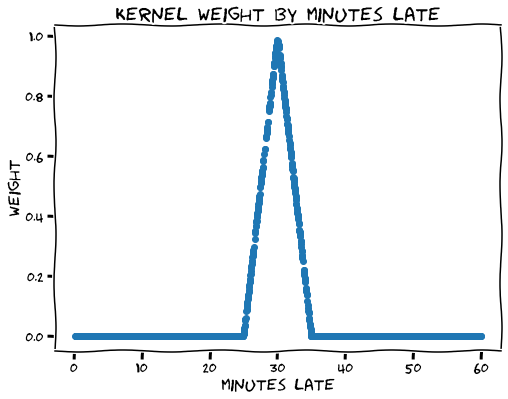

In [ ]:
with plt.xkcd():
    # choose 5 as bandwith and plot kernel weight
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(df_late["min_late"], df_late["weight"])
    ax.set_xlabel("minutes late", fontsize=17)
    ax.set_ylabel("weight", fontsize=17)
    ax.set_title("kernel weight by minutes late", fontsize=20)
    fig.savefig("kernel_weight.png", dpi=300)

In [ ]:
# fit model using weighted data
model_kernel_weight = smf.wls(
    "ltv ~ min_late_centered * refunded",
    df_late,
    weights=df_late["weight"],
).fit()


model_kernel_weight.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,50.9816,0.537,94.889,0.000,49.928,52.035
min_late_centered,-0.9080,0.268,-3.382,0.001,-1.434,-0.381
refunded,8.4211,0.787,10.694,0.000,6.877,9.965
min_late_centered:refunded,0.0806,0.393,0.205,0.838,-0.691,0.852


After applying kernel weighting, the treatment effect of getting a refund is estimated to be 8.42 dollars.

In [ ]:
# extract coefficients from model
b0_kw = model_kernel_weight.params["Intercept"]
b1_kw = model_kernel_weight.params["min_late_centered"]
b2_kw = model_kernel_weight.params["refunded"]
b3_kw = model_kernel_weight.params["min_late_centered:refunded"]

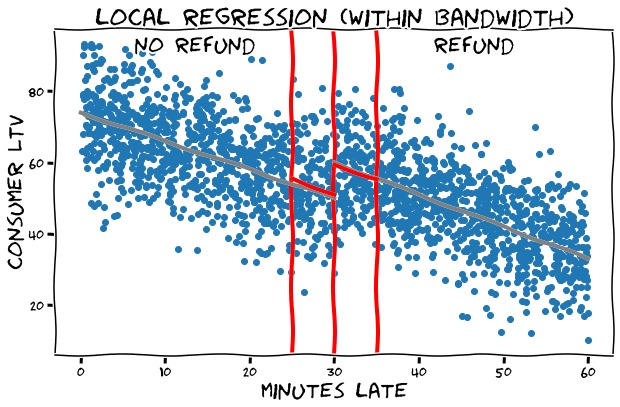

In [ ]:
with plt.xkcd():
    # plot relationship between LTV and minutes late witin bandwidth
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(df_late["min_late"], df_late["ltv"])
    ax.set_xlabel("minutes late", fontsize=22)
    ax.set_ylabel("consumer LTV", fontsize=22)
    ax.set_title("local regression (within bandwidth)", fontsize=25)

    # draw vertical lines to indicate cutoff and bandwidth
    ax.axvline(x=CUTOFF, linewidth=4, color="r")
    ax.axvline(x=CUTOFF + 5, linewidth=4, color="r")
    ax.axvline(x=CUTOFF - 5, linewidth=4, color="r")

    # draw regression lines for untreated side
    x_untreated = np.linspace(LOWER, CUTOFF, 1000)
    x_untreated_kernel = np.linspace(CUTOFF - 5, CUTOFF, 1000)
    ltv_untreated = B0 + B1 * (x_untreated - CUTOFF)
    ltv_untreated_kernel = b0_kw + b1_kw * (x_untreated_kernel - CUTOFF)
    ax.plot(x_untreated, ltv_untreated, linewidth=4, color="grey")
    ax.plot(x_untreated_kernel, ltv_untreated_kernel, linewidth=4, color="red")

    # draw regression lines for treated side
    x_treated = np.linspace(CUTOFF, UPPER, 1000)
    x_treated_kernel = np.linspace(CUTOFF, CUTOFF + 5, 1000)
    ltv_treated = (B0 + B2) + (B1 + B3) * (x_treated - CUTOFF)
    ltv_treated_kernel = (b0_kw + b2_kw) + (b1_kw + b3_kw) * (
        x_treated_kernel - CUTOFF
    )
    ax.plot(x_treated, ltv_treated, linewidth=4, color="grey")
    ax.plot(x_treated_kernel, ltv_treated_kernel, linewidth=4, color="red")

    # annotate refund status of each side
    ax.text(
        0.25,
        0.95,
        "no refund",
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
        fontsize=22,
    )

    ax.text(
        0.75,
        0.95,
        "refund",
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
        fontsize=22,
    )

    fig.savefig("rdd_kernel_weight.png", dpi=300)